In [134]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb #type: ignore


## Description of Potential, Force, and Langevin Dynamics

### Potential Function
The potential function describes the energy landscape of the system. In this notebook, we use a symmetric double well potential defined as:
$$
 V(x, y) = 0.5 \left( (x^2 - 1)^2 + y^2 \right) 
$$

This potential has two minima at $ x = \pm 1 $ and $ y = 0 $, separated by a barrier at $ x = 0 $.

### Force Function
The force acting on a particle in the potential field is derived from the negative gradient of the potential. For the given potential, the force components are:
$$
 F_x(x, y) = -\frac{\partial V}{\partial x} = -2(x^2 - 1)x 
 $$
$$
 F_y(x, y) = -\frac{\partial V}{\partial y} = -y 
$$
### Langevin Dynamics
Langevin dynamics is a stochastic approach to simulate the motion of particles in a potential field, accounting for both deterministic forces and random thermal fluctuations. The equations of motion are given by:
$$
 m \frac{d^2 x}{dt^2} = F_x - \gamma \frac{dx}{dt} + \sqrt{2 \gamma k_B T} \eta_x(t) $$
$$
 m \frac{d^2 y}{dt^2} = F_y - \gamma \frac{dy}{dt} + \sqrt{2 \gamma k_B T} \eta_y(t) $$
 
where:
- $m$ is the mass of the particle
- $\gamma $ is the friction coefficient
- $ k_B $ is the Boltzmann constant
- $ T $ is the temperature
- $\eta_x(t) $ and $ \eta_y(t) $ are Gaussian white noise terms

In this notebook, we use the Langevin dynamics simulation to generate trajectories of particles at different temperatures.

In [193]:
# Potential function for 2D well
@nb.jit(nopython=True)
def potential(x, y):
    return 2.5 * ((x**2 -1)**2 + y**2)

# Force derived from the potential
@nb.jit(nopython=True)
def force(x, y):
    return -10.0*(x**2 -1)*x, -5.0*y

# Langevin dynamics simulation
@nb.jit(nopython=True)
def langevin_dynamics(T, dt, gamma, num_steps=100000, skip_steps=100):
    k_B = 1.0 # Boltzmann constant
    m = 1.0 # mass of the particle
    x, y = 0.0, 0.0  # initial position
    vx, vy = 0.0, 0.0  # initial velocity
    trajectory = []

    for i in range(num_steps):
        fx, fy = force(x, y)
        vx += (fx - gamma * vx) * dt / m + np.sqrt(2 * gamma * k_B * T / m) * np.random.normal(0, np.sqrt(dt))
        vy += (fy - gamma * vy) * dt / m + np.sqrt(2 * gamma * k_B * T / m) * np.random.normal(0, np.sqrt(dt))
        x += vx * dt
        y += vy * dt
        if i % skip_steps == 0:
            trajectory.append((x, y))

    return np.array(trajectory)

In [194]:
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'axes.linewidth': 1,
    'lines.markersize': 6,
    'font.family': 'serif',
    'font.serif': ['C059'],
    'savefig.dpi': 300,
    'savefig.format': 'png',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

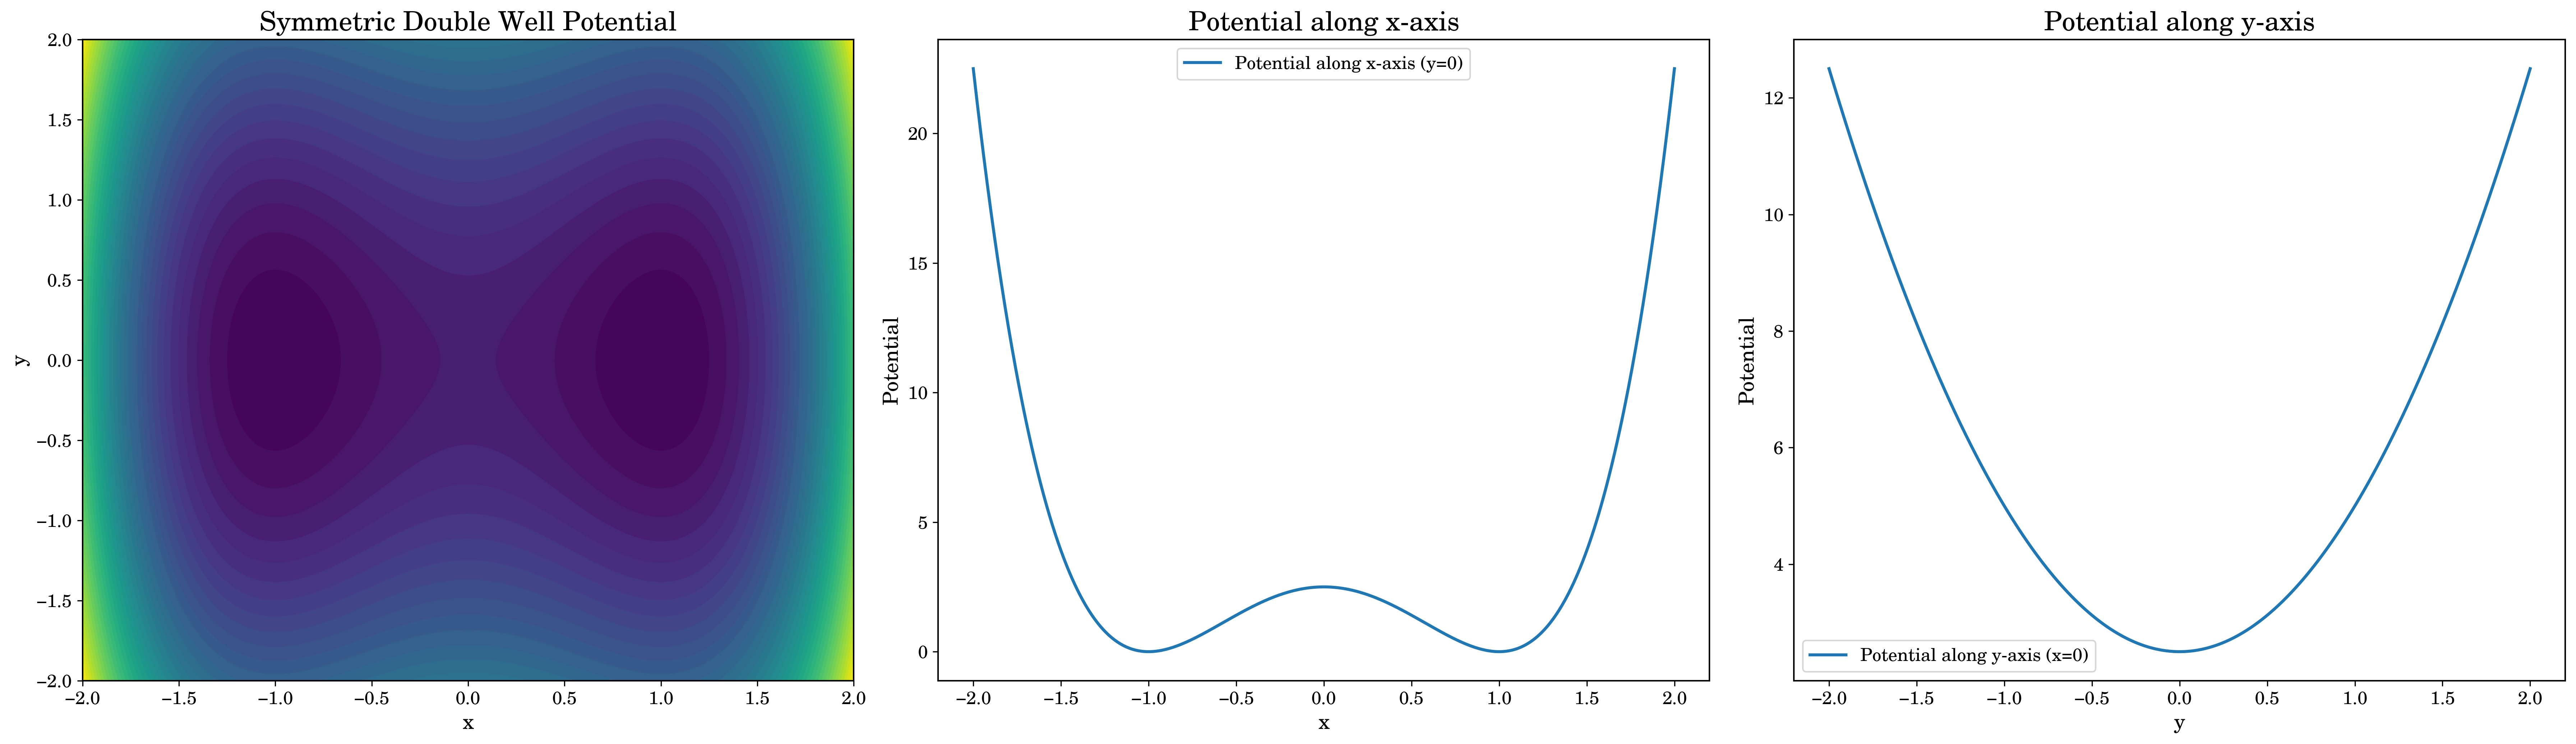

In [195]:
# Dissect contour plot and plot individual axes
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = potential(X, Y)
fig, ax = plt.subplots(1, 3, figsize=(24, 7), dpi = 300)
# Plot the contour plot

m = ax[0].contourf(X, Y, Z, levels=50, cmap='viridis')
#ax[0].colorbar(label='Potential')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Symmetric Double Well Potential')

# Plot the potential along the x-axis (y=0)

ax[1].plot(x, potential(x, 0), label='Potential along x-axis (y=0)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Potential')
ax[1].set_title('Potential along x-axis')
ax[1].legend()

# Plot the potential along the y-axis (x=0)
ax[2].plot(y, potential(0, y), label='Potential along y-axis (x=0)')
ax[2].set_xlabel('y')
ax[2].set_ylabel('Potential')
ax[2].set_title('Potential along y-axis')
ax[2].legend()
fig.tight_layout()
plt.show()

In [196]:
# Parameters
gamma = 1.0  # friction coefficient
dt = 0.01  # time step
temperatures = [0.5, 1.0, 2.0]  # different temperatures

In [215]:
# Different Langevin dynamics simulations at different temperatures
traj1 = langevin_dynamics(0.5, dt, gamma, num_steps = 10000000, skip_steps=10)
traj2 = langevin_dynamics(1.0, dt, gamma, num_steps = 10000000, skip_steps=10)
traj3 = langevin_dynamics(2.0, dt, gamma, num_steps = 10000000, skip_steps=10)

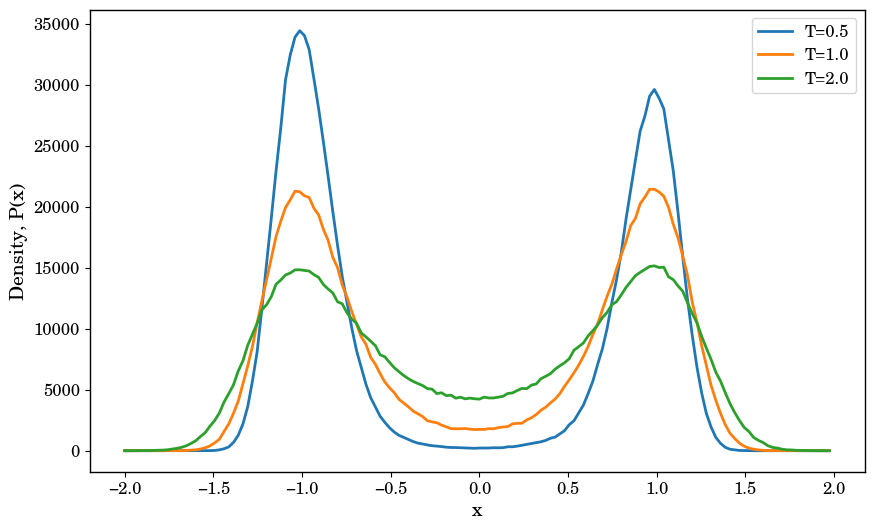

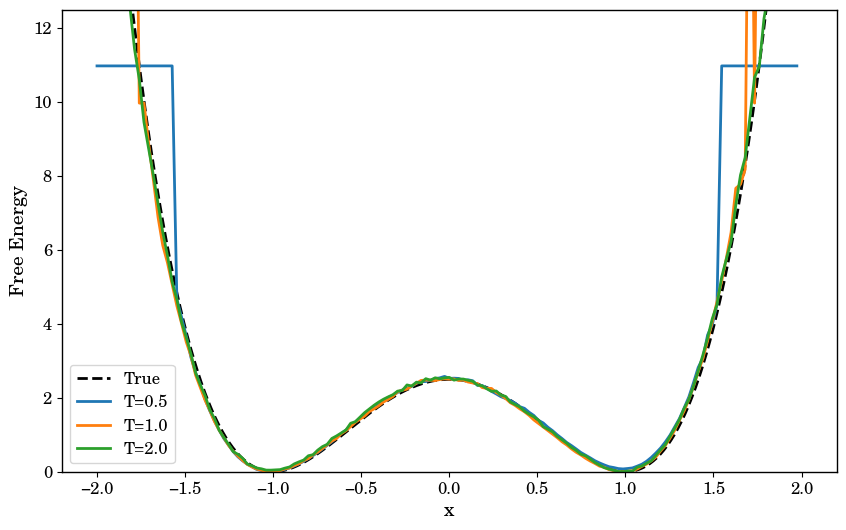

In [216]:
def plot_free_energy(traj, temperature, bins=150, range=(-2, 2)):
    h, b = np.histogram(traj[:, 0], bins=bins, range=range)
    h = h.astype(np.float64)
    h[h == 0] = 1e-5  # Avoid log(0)
    free_energy = -np.log(h)
    free_energy -= free_energy.min()  # Normalize to have minimum value of zero

    ax.plot(b[:-1], temperature * free_energy, label=f'T={temperature}')

def plot_density(traj, temperature, bins=150, range=(-2, 2)):
    h, b = np.histogram(traj[:, 0], bins=bins, range=range)
    h = h.astype(np.float64)

    ax.plot(b[:-1], h, label=f'T={temperature}')

# Example usage
fig, ax = plt.subplots()
plot_density(traj1, 0.5)
plot_density(traj2, 1.0)
plot_density(traj3, 2.0)
ax.set_xlabel('x')
ax.set_ylabel('Density, P(x)')
#ax.set_ylim(0, 12.5)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(x, potential(x, 0), label='True', c = 'black', ls = "--")
plot_free_energy(traj1, 0.5)
plot_free_energy(traj2, 1.0)
plot_free_energy(traj3, 2.0)
ax.set_xlabel('x')
ax.set_ylabel('Free Energy')
ax.set_ylim(0, 12.5)
ax.legend()
plt.show()